In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
import scipy.misc
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import torchvision.models as models

seed = 0
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
device = torch.device('cpu')

In [3]:
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.RandomVerticalFlip())
transforms.RandomRotation(180, expand=True)
train_transform.transforms.append(transforms.RandomResizedCrop(572, scale=(0.08, 1.0), ratio=(1.0,1.0)))
train_transform.transforms.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0))
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(transforms.Normalize([0.4373, 0.4434, 0.4725],[0.1201, 0.1231, 0.1052]))
train_transform.transforms.append(transforms.RandomErasing())

In [4]:
test_transform = transforms.Compose([])
test_transform.transforms.append(transforms.RandomResizedCrop(572, scale=(1.0, 1.0), ratio=(1.0,1.0)))
test_transform.transforms.append(transforms.ToTensor())
test_transform.transforms.append(transforms.Normalize([0.4373, 0.4434, 0.4725],[0.1201, 0.1231, 0.1052]))

In [5]:
class image_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_name = self.df.iloc[idx]['image']
        image_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Data/classification/images_preprocessed/'\
        + image_name + '.jpg'
        image = Image.open(image_path)
        
        if self.train:
            image_tensor = train_transform(image)
        else:
            image_tensor = test_transform(image)
            
        metadata = self.df.loc[idx][['sex_index','age_index','anterior torso', 'head/neck', 'lateral torso',\
                                     'lower extremity','oral/genital', 'palms/soles', 'posterior torso',\
                                     'upper extremity']].values.astype('float')
        metadata = torch.tensor(metadata, dtype=torch.float)
        label = self.df.loc[idx][['MEL','NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC','UNK']].values.astype('float')
        label = torch.tensor(label, dtype=torch.float)
        label = label.data.max(-1)[1]
        sample = {'x1': image_tensor, 'x2':metadata,'y': label}
        
        return sample

In [6]:
train_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/train.csv'
val_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/val.csv'
test_df_path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/test.csv'
BATCH_SIZE = 16
train_loader = DataLoader(image_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, shuffle=True,num_workers=8)
val_loader = DataLoader(image_dataset(val_df_path), batch_size=BATCH_SIZE, shuffle=True,num_workers=8)
test_loader = DataLoader(image_dataset(test_df_path), batch_size=BATCH_SIZE, shuffle=False,num_workers=8)

In [7]:
image_tensor = next(iter(train_loader))['x1'][0]

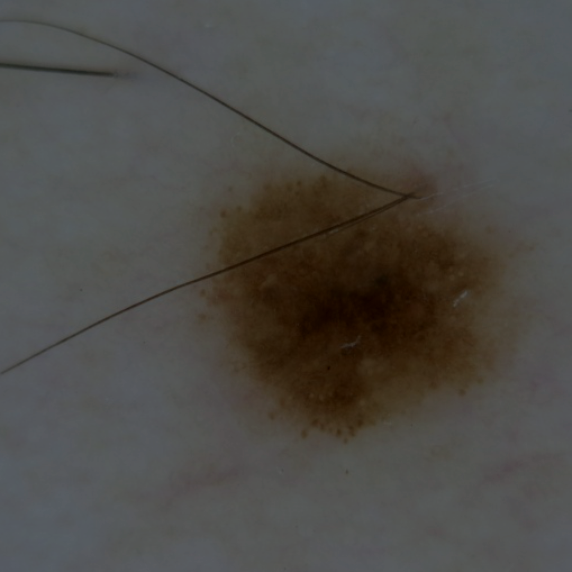

In [8]:
inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
image = inv_normalize(image_tensor)
transforms.ToPILImage()(image)

In [9]:
resnet18 = models.resnet18()

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = resnet18.conv1
        self.bn1 = resnet18.bn1
        self.relu = resnet18.relu
        self.maxpool = resnet18.maxpool
        self.layer1 = resnet18.layer1
        self.layer2 = resnet18.layer2
        self.layer3 = resnet18.layer3
        self.layer4 = resnet18.layer4
        self.avgpool = resnet18.avgpool
        self.fc = nn.Linear(512, 9)
        
    def forward(self, image, data):
        x = self.conv1(image)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        
        return x

In [11]:
sample = next(iter(train_loader))
image = sample['x1'].to('cpu')
data = sample['x2'].to('cpu')
model = MyModel().to('cpu')
output = model(image,data)

In [12]:
output.shape

torch.Size([16, 9])

In [13]:
def train(model, train_loader=train_loader, val_loader=val_loader, learning_rate=5e-5, num_epoch=100):
    start_time = time.time()
    
    distribution = torch.FloatTensor([0.17652477, 0.50707283, 0.13323245, 0.03348905, \
                                  0.10494111, 0.00894796, 0.00986907, 0.02592276, 0.]).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=distribution)
    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    
    train_loss_return = []
    train_acc_return = []
    val_loss_return = []
    val_acc_return = []
    best_acc = 0
    
    for epoch in range(num_epoch):
        # Training steps
        correct = 0
        total = 0
        predictions = []
        truths = []
        model.train()
        train_loss_list = []
        for i, (sample) in enumerate(train_loader):
            image = sample['x1'].to(device)
            data = sample['x2'].to(device)
            labels = sample['y'].to(device)
            outputs = model(image,data)
            pred = outputs.data.max(-1)[1]
            predictions += list(pred.cpu().numpy())
            truths += list(labels.cpu().numpy())
            total += labels.size(0)
            correct += (pred == labels).sum()
            model.zero_grad()
            loss = loss_fn(outputs, labels)
            print(loss)
            train_loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
        # report performance
        acc = (100 * correct / total)
        train_acc_return.append(acc)
        train_loss_every_epoch = np.average(train_loss_list)
        train_loss_return.append(train_loss_every_epoch)
        print('----------Epoch{:2d}/{:2d}----------'.format(epoch+1,num_epoch))
        print('Train set | Loss: {:6.4f} | Accuracy: {:4.2f}% '.format(train_loss_every_epoch, acc))
        
        # Evaluate after every epochh
        correct = 0
        total = 0
        model.eval()
        predictions = []
        truths = []
        val_loss_list = []
        with torch.no_grad():
            for i, (sample) in enumerate(val_loader):
                image = sample['x1'].to(device)
                data = sample['x2'].to(device)
                labels = sample['y'].to(device)
                outputs = model(image,data)
                loss = loss_fn(outputs, labels)
                val_loss_list.append(loss.item())
                pred = outputs.data.max(-1)[1]
                predictions += list(pred.cpu().numpy())
                truths += list(labels.cpu().numpy())
                total += labels.size(0)
                correct += (pred == labels).sum()
            # report performance
            acc = (100 * correct / total)
            val_acc_return.append(acc)
            val_loss_every_epoch = np.average(val_loss_list)
            val_loss_return.append(val_loss_every_epoch)
            if acc > best_acc:
                best_acc = acc
                best_model_wts = model.state_dict()
            save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts)
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print('Test set | Loss: {:6.4f} | Accuracy: {:4.2f}% | time elapse: {:>9}'\
                  .format(val_loss_every_epoch, acc,elapse))
    return model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts

def save_model(model,train_loss_return,train_acc_return,val_loss_return,val_acc_return,best_model_wts):
    state = {'best_model_wts':best_model_wts, 'model':model, \
             'train_loss':train_loss_return, 'train_acc':train_acc_return,\
             'val_loss':val_loss_return, 'val_acc':val_acc_return}
    torch.save(state, 'checkpoint_Model_ResNet18.pt')
    return None

In [14]:
model = MyModel().to(device)

In [15]:
#train(model)

## CAM

In [16]:
import cv2

In [17]:
path = '/scratch/cz2064/myjupyter/Computer Vision/Project/Jupyter Notebook/py files/ResNet18/checkpoint_Model_ResNet18.pt'
model.load_state_dict(torch.load(path,map_location=device)['best_model_wts'])


<All keys matched successfully>

In [18]:
class CAM_Model(nn.Module):
    def __init__(self):
        super(CAM_Model, self).__init__()
        self.conv1 = resnet18.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        self.avgpool = model.avgpool
        self.fc = model.fc
        
    def forward(self, image, data):
        x = self.conv1(image)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        self.featuremap1 = x.detach()
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        
        return x

In [19]:
cam_model = CAM_Model()

In [43]:
BATCH_SIZE = 1
test_loader = DataLoader(image_dataset('test-Copy1.csv'), batch_size=BATCH_SIZE, shuffle=True)

In [44]:
sample = next(iter(test_loader))
sample_input = sample['x1'].to(device,dtype=torch.float)
sample_lable = sample['y']


In [45]:
cam_model.eval()
output = cam_model(sample_input,_)
pre_class = output.data.max(-1)[1].cpu().numpy()
pre_class

array([0])

In [46]:
Feature_map = cam_model.featuremap1.cpu().numpy()
print('Feature map:',Feature_map.shape)

Feature map: (1, 512, 18, 18)


In [47]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
print('Weights:',weight_softmax.shape)

Weights: (9, 512)


In [48]:
weights_map1 = weight_softmax[pre_class]
cam_1 = weights_map1.dot(Feature_map.reshape((512,18*18)))
cam_1 = cam_1.reshape(18,18)

In [49]:
cam_img = cam_1 / np.max(cam_1)
cam_img = np.uint8(255 * cam_img)

In [50]:
CAM = cv2.resize(cam_img, (572,572))

In [51]:
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)

In [52]:
inv_normalize = transforms.Normalize(mean=[-0.4373/0.1201, -0.4434/0.1231, -0.4725/0.1052],\
                                     std=[1/0.1201, 1/0.1231, 1/0.1052])
image = inv_normalize(sample_input[0])

image = transforms.ToPILImage()(image)

image.save('sample.jpg')

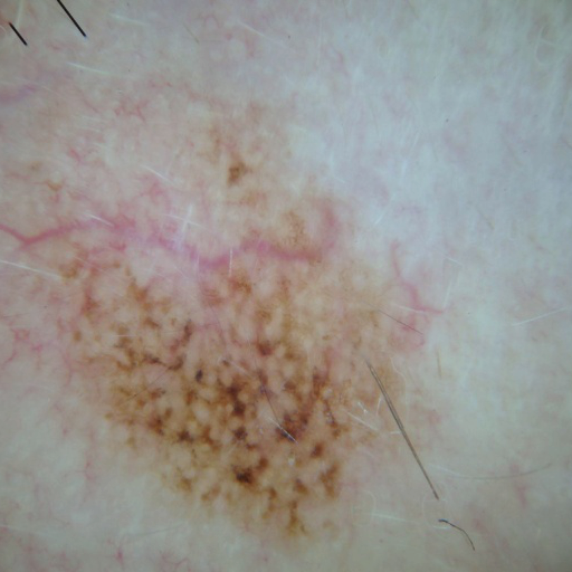

In [53]:
image

In [54]:
img = cv2.imread('sample.jpg')

In [55]:
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

True